In this notebook we show how you can access elements of a graph. We pretend not to know anything about the graph.

The weights for the model can be downloaded as described in http://randomthoughtsonr.blogspot.de/2016/11/image-classification-in-r-using-trained.html

### Definition of the model

We now load the network in a session. We do it deliverably stupid and do not keep track of the entry points of the graph. 

In [1]:
# Further information
# Google Blog Entry https://research.googleblog.com/2016/08/improving-inception-and-image.html
# Models to Train   https://github.com/tensorflow/models/blob/master/slim/README.md#Tuning
# Transfer Learning http://stackoverflow.com/questions/40350539/tfslim-problems-loading-saved-checkpoint-for-vgg16

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from imagenet_classes import class_names

tf.reset_default_graph()
images = tf.placeholder(tf.float32, [None, None, None, 3])
imgs_scaled = tf.image.resize_images(images, (224,224))

# Note we call the network studid, so that we don't get a hold for the tensors we need.
slim.nets.vgg.vgg_16(imgs_scaled, is_training=False)
variables_to_restore = slim.get_variables_to_restore()
print('Number of variables to restore {}'.format(len(variables_to_restore)))
init_assign_op, init_feed_dict = slim.assign_from_checkpoint('/Users/oli/Dropbox/server_sync/tf_slim_models/vgg_16.ckpt', variables_to_restore)
sess = tf.Session()
sess.run(init_assign_op, init_feed_dict)

Number of variables to restore 32


### Task
Let's determine the race of that dog:

(390, 460, 3)
Some pixels [170 169 159 160 164 170]


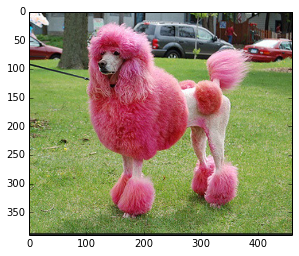

In [2]:
img1 = imread('poodle.jpg')
print(img1.shape)
print("Some pixels {}".format(img1[199,199:205,0]))
plt.imshow(img1)
plt.show()

## Getting relevant entry points

Suppose we know nothing about the graph. How to determine the relevant entry points. One way would be to use the tensorboard via:

In [3]:
tf.train.SummaryWriter('/tmp/dumm/vgg16', tf.get_default_graph()).close()
#tensorboard --logdir /tmp/dumm/

Another option to find the relevant entry points is to loop over all ops in the graph and print them

In [4]:
ops = tf.get_default_graph().get_operations()
for i in ops[0:9]:
    print i.name

Placeholder
size
ResizeBilinear
vgg_16/conv1/conv1_1/weights
vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/shape
vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/min
vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/max
vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/RandomUniform
vgg_16/conv1/conv1_1/weights/Initializer/random_uniform/sub


In [5]:
g = tf.get_default_graph()
g.get_tensor_by_name('Placeholder:0')

<tf.Tensor 'Placeholder:0' shape=(?, ?, ?, 3) dtype=float32>

We find that we want to use the entry point with the name `Placeholder` the **feed** and the exit point with the name `vgg_16/fc8/Relu` the **fetch**. These are ops! The respective tensors are then the zero's output and named `Placeholder:0` and `vgg_16/fc8/Relu:0`

In [6]:
g = tf.get_default_graph()
feed = g.get_tensor_by_name('Placeholder:0')
fetch = g.get_tensor_by_name('vgg_16/fc8/BiasAdd:0')

Alternatively

In [7]:
feed = tf.Graph.get_tensor_by_name(tf.get_default_graph(), 'Placeholder:0')
fetch = tf.Graph.get_tensor_by_name(tf.get_default_graph(), 'vgg_16/fc8/BiasAdd:0')

In [8]:
feed.get_shape(), fetch.get_shape()

(TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(3)]),
 TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(1000)]))

In [9]:
# Make a tensor of order 4
feed_vals = [img1]
np.shape(feed_vals)

(1, 390, 460, 3)

In [10]:
res = sess.run(fetch, feed_dict={feed:feed_vals})

In [11]:
res.shape

(1, 1, 1, 1000)

In [12]:
d = res[0,0,0,]
prob = np.exp(d)/np.sum(np.exp(d))
preds = (np.argsort(prob)[::-1])[0:10]
for p in preds:
    print p, class_names[p], prob[p]

267 standard poodle 0.991464
265 toy poodle 0.0036847
266 miniature poodle 0.00303289
160 Afghan hound, Afghan 0.000330886
221 Irish water spaniel 0.000312829
355 llama 0.000262452
244 Tibetan mastiff 0.000241841
368 gibbon, Hylobates lar 0.000104725
903 wig 9.71746e-05
260 chow, chow chow 4.49079e-05


## Getting variables

Sometimes it is also interesting to investigate the variables in the model.

In [13]:
# First method use the variable scope mechanism and sharing
with tf.variable_scope("vgg_16/conv1/conv1_1", reuse=True):
    var = tf.get_variable("weights")
    conv1_1 = sess.run(var)

In [14]:
# Second method use the variable tensor by name
var = tf.get_default_graph().get_tensor_by_name("vgg_16/conv1/conv1_1/weights:0")
conv1_1_alt = sess.run(var)

In [15]:
# Third method (python magic). List all variables and pick the right one
var = [v for v in tf.all_variables() if v.name == 'vgg_16/conv1/conv1_1/weights:0'][0]
conv1_1_alt_3 = sess.run(var)

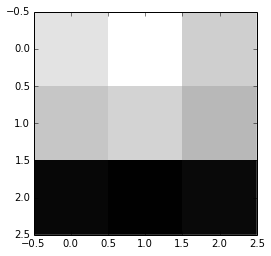

In [16]:
plt.imshow(conv1_1[0,:,:,0], interpolation='none', cmap=plt.get_cmap('gray'))

In [17]:
sess.close()